In [1]:
import numpy as np
from sklearn.model_selection import KFold
import random
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from cnn_finetune import make_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import seaborn as sns

from sklearn.metrics import auc

from efficientnet_pytorch import EfficientNet
import torchvision.models as models

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# SqueezeNetモデルを事前学習済みモデルとしてロード
model = models.squeezenet1_1(pretrained=True)

# SqueezeNetの最終層の入力特徴量数を取得
# SqueezeNetではclassifierの第2層が最終層です
num_ftrs = model.classifier[1].in_channels

# 最終層を4クラスの出力に変更
model.classifier[1] = nn.Conv2d(num_ftrs, 4, kernel_size=(1,1))

# 最終層の出力の形状を変更
model.num_classes = 4

# すべての層を訓練可能に設定
for param in model.parameters():
    param.requires_grad = True

# モデルをデバイスに移動
model = model.to(device)
print(model)

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [3]:
#データセットの設定
train_dataset = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/GCB Non-GCB MALT Normal -最終/train')  #学習用データ：データ数は560
test_dataset  = torchvision.datasets.ImageFolder(root='/home/yamaguchi/最終/GCB Non-GCB MALT Normal -最終/test') 

transform = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # ランダムに画像を水平方向に反転
    transforms.RandomHorizontalFlip(),
    # ランダムに画像の色調を変更
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_2 = torchvision.transforms.Compose([
    transforms.RandomCrop((224,224)),
    # グレースケールに変換（3チャンネル出力）
    transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


batch_size = 32

train_dataset.transform=transform
test_dataset.transform=transform_2
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

print(train_dataset.classes)


['1 normal', '2 MALT', '3 GCB', '4 Non-GCB']


In [4]:
from torchsummary import summary

summary(model, (3, 224, 224))

#https://discuss.pytorch.org/t/what-is-1-in-output-shape-of-a-model-in-torch-summary/67790

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

In [5]:
# Train
def train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader):
    # Early stoppingの設定
    the_last_loss = 100  
    patience = 10
    trigger_times = 0

    for epoch in range(100):
        model.train()
        running_loss = 0.0
        correct_num = 0
        total_num = 0
        batch_count = 0

        for data,target in  cv_train_dataloader:
            inputs, labels = data.to(device), target.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            predicted = torch.max(outputs.data, 1)[1]
            correct_num_temp = (predicted==labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_count += 1 

        print('epoch:%d loss: %.3f acc: %.3f' %
             (epoch + 1, running_loss / batch_count, correct_num*100/total_num))
            

        # Early stopping
        the_current_loss = validation(model, device, cv_valid_dataloader, criterion)
        print('The current loss:', the_current_loss)

        if the_current_loss > the_last_loss:
            trigger_times += 1
            print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        the_last_loss = the_current_loss

    return model

In [6]:
#validation

def validation(model, device, cv_valid_dataloader, criterion):
    model.eval()
    running_loss = 0

    with torch.no_grad():
        for data,target in cv_valid_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(cv_valid_dataloader)

In [7]:

def test(device, model, test_dataloader):
    model.eval()
    
    correct_num = 0
    total_num = 0
    predicts_list = []
    labels_list = []
    scores_list=[] 

    with torch.no_grad():
        for data, target in test_dataloader:
            inputs, labels = data.to(device), target.to(device)

            outputs = model(inputs)
            m = nn.Softmax(dim=1)
            probs = m(outputs)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_num_temp = (predicted == labels).sum()
            correct_num += correct_num_temp.item()
            total_num += data.shape[0]

            device2 = torch.device('cpu')
            labels=labels.to(device2)
            predicted = predicted.to(device2)
            probs = probs.to(device2)

            labels_list.append(labels)
            predicts_list.append(predicted)
            scores_list.append(probs)  
    
        labels = torch.cat(labels_list)
        predicted = torch.cat(predicts_list)
        scores = torch.cat(scores_list)  

        labels_bin = label_binarize(labels, classes=[0, 1, 2, 3])  # Changed to four classes

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(4):  # Changed loop range to four classes
            fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        C = confusion_matrix(labels, predicted)
        ac = accuracy_score(labels, predicted)
        pre = precision_score(labels, predicted, average='macro')
        re = recall_score(labels, predicted, average='macro')
        f1 = f1_score(labels, predicted, average='macro')

        AUC = roc_auc_score(labels, scores, multi_class='ovr')  

        print(C)
        print("\n")
        print("test accuracy : %.3f" % ac)
        print("test precison : %.3f" % pre)
        print("test recall : %.3f" % re)
        print("test f : %.3f" % f1)
        print("AUC : %.3f" %(AUC))

        for i in range(4):  # Changed loop range to four classes
            print("AUC for class {}: {:.3f}".format(i, roc_auc[i]))

        # Compute macro-average ROC curve and ROC area
        fpr_macro = dict()
        tpr_macro = dict()
        roc_auc_macro = dict()
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))  # Changed loop range to four classes
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(4):  # Changed loop range to four classes
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= 4  # Changed the denominator to four classes
        fpr_macro["macro"] = all_fpr
        tpr_macro["macro"] = mean_tpr
        roc_auc_macro["macro"] = auc(fpr_macro["macro"], tpr_macro["macro"])

        # Plot all ROC curves
        plt.figure()
        plt.plot(fpr_macro["macro"], tpr_macro["macro"],
                 label='macro-average ROC curve (area = {:.3g})'.format(roc_auc_macro["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])  # Added one more color for the additional class
        class_labels = ['Normal lymph node', 'MALT lymphoma', 'GCB', 'Non-GCB']  # Changed to four class labels
        for i, color in zip(range(4), colors):  # Changed loop range to four classes
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='ROC curve of class {0} (area = {1:.3g})'
                     ''.format(class_labels[i], roc_auc[i]))

            
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        
        class_labels = ['normal lymph nodes', 'MALToma', 'GCB', 'non-GCB']   # Changed to four class labels
        C = confusion_matrix(labels, predicted)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(C, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels,annot_kws={'size': 20})
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
        plt.show()

            

In [8]:
#k分割交差検証

kf = KFold(n_splits=10)

Fold 1------------------------------------------------------------------------------
epoch:1 loss: 0.971 acc: 57.833
The current loss: 0.7661521516738262
trigger times: 0
epoch:2 loss: 0.805 acc: 64.350
The current loss: 0.7075600412442105
trigger times: 0
epoch:3 loss: 0.728 acc: 68.827
The current loss: 0.8492592048503673
trigger times: 1
epoch:4 loss: 0.714 acc: 69.224
The current loss: 0.6405151561534467
trigger times: 0
epoch:5 loss: 0.651 acc: 71.458
The current loss: 0.584566657099434
trigger times: 0
epoch:6 loss: 0.586 acc: 74.864
The current loss: 0.5516436740862577
trigger times: 0
epoch:7 loss: 0.571 acc: 75.935
The current loss: 0.5446464151630938
trigger times: 0
epoch:8 loss: 0.550 acc: 76.655
The current loss: 0.5692928947069116
trigger times: 1
epoch:9 loss: 0.531 acc: 77.873
The current loss: 0.4893603936636341
trigger times: 0
epoch:10 loss: 0.519 acc: 78.372
The current loss: 0.5618468370202072
trigger times: 1
epoch:11 loss: 0.475 acc: 80.578
The current loss: 0.37

epoch:94 loss: 0.104 acc: 96.021
The current loss: 0.0659516440402666
trigger times: 1
epoch:95 loss: 0.088 acc: 96.714
The current loss: 0.057513410973906186
trigger times: 0
epoch:96 loss: 0.104 acc: 96.178
The current loss: 0.10803069193045632
trigger times: 1
epoch:97 loss: 0.115 acc: 95.901
The current loss: 0.09776461428983199
trigger times: 0
epoch:98 loss: 0.091 acc: 96.880
The current loss: 0.05418454325958711
trigger times: 0
epoch:99 loss: 0.094 acc: 96.501
The current loss: 0.045969139320276624
trigger times: 0
epoch:100 loss: 0.080 acc: 97.194
The current loss: 0.09924556811521569
trigger times: 1
[[ 77  11   2  60]
 [  0  13  48  61]
 [  0   1  49 160]
 [  0   0  87 393]]


test accuracy : 0.553
test precison : 0.592
test recall : 0.418
test f : 0.446
AUC : 0.807
AUC for class 0: 0.943
AUC for class 1: 0.941
AUC for class 2: 0.621
AUC for class 3: 0.725


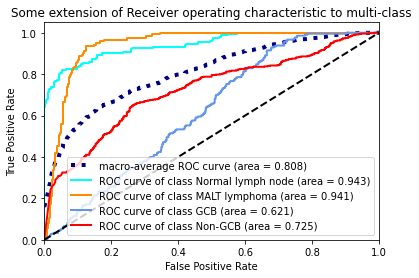

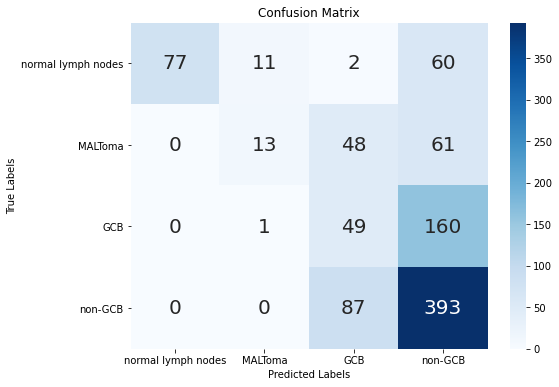

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 2------------------------------------------------------------------------------
epoch:1 loss: 0.996 acc: 56.503
The current loss: 0.8591800577655503
trigger times: 0
epoch:2 loss: 0.848 acc: 62.854
The current loss: 0.7567758064495212
trigger times: 0
epoch:3 loss: 0.786 acc: 65.180
The current loss: 0.7119253443036871
trigger times: 0
epoch:4 loss: 0.742 acc: 67.608
The current loss: 0.7555536526313003
trigger times: 1
epoch:5 loss: 0.700 acc: 69.316
The current loss: 0.6605763852116899
trigger times: 0
epoch:6 loss: 0.666 acc: 70.931
The current loss: 0.6059796449992525
trigger times: 0
epoch:7 loss: 0.643 acc: 72.131
The current loss: 0.5596805458165881
trigger times: 0
epoch:8 loss: 0.597 acc: 74.292
The current loss: 0.5653610289657274
trigger times: 1
epoch:9 loss: 0.568 acc: 76.138
The current loss: 0.5980491352941587
trigger times: 2
epoch:10 loss: 0.547 acc: 76.839
The current loss: 0.6208006008473228
trigger times: 3
epoch:11 loss: 0.519 acc: 77.273
The current loss: 0.4

epoch:94 loss: 0.100 acc: 96.178
The current loss: 0.10442694286783182
trigger times: 1
epoch:95 loss: 0.108 acc: 96.058
The current loss: 0.09463874147901298
trigger times: 0
epoch:96 loss: 0.092 acc: 96.483
The current loss: 0.11167495514396727
trigger times: 1
epoch:97 loss: 0.108 acc: 95.994
The current loss: 0.10395524521537941
trigger times: 0
epoch:98 loss: 0.091 acc: 96.501
The current loss: 0.2286290235885342
trigger times: 1
epoch:99 loss: 0.102 acc: 96.224
The current loss: 0.05844251415246611
trigger times: 0
epoch:100 loss: 0.098 acc: 96.372
The current loss: 0.1299036166968412
trigger times: 1
[[ 96  25   3  26]
 [  0  42  12  68]
 [  0   3  23 184]
 [  0   9  43 428]]


test accuracy : 0.612
test precison : 0.605
test recall : 0.496
test f : 0.520
AUC : 0.819
AUC for class 0: 0.991
AUC for class 1: 0.927
AUC for class 2: 0.578
AUC for class 3: 0.782


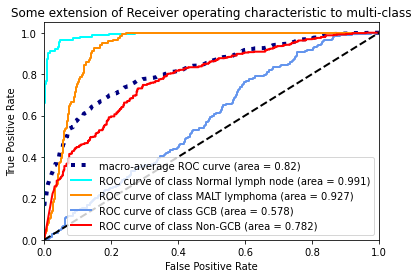

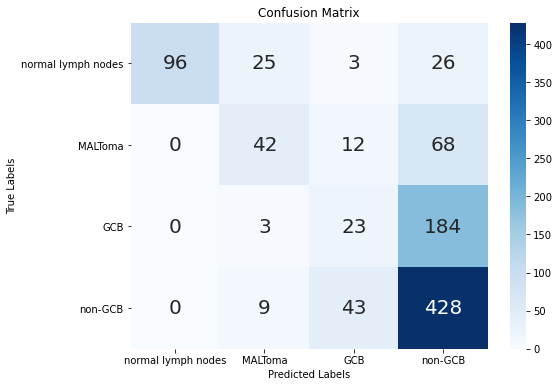

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 3------------------------------------------------------------------------------
epoch:1 loss: 0.952 acc: 58.377
The current loss: 1.013780236756223
trigger times: 0
epoch:2 loss: 0.817 acc: 63.971
The current loss: 0.7680234601391496
trigger times: 0
epoch:3 loss: 0.738 acc: 67.830
The current loss: 0.6535996412315782
trigger times: 0
epoch:4 loss: 0.698 acc: 69.390
The current loss: 0.7212978259496842
trigger times: 1
epoch:5 loss: 0.683 acc: 70.341
The current loss: 0.6488563540037227
trigger times: 0
epoch:6 loss: 0.621 acc: 73.359
The current loss: 0.6512552367229355
trigger times: 1
epoch:7 loss: 0.596 acc: 74.319
The current loss: 0.6131032172627711
trigger times: 0
epoch:8 loss: 0.571 acc: 75.870
The current loss: 0.48806508898330825
trigger times: 0
epoch:9 loss: 0.560 acc: 76.442
The current loss: 0.562643904199045
trigger times: 1
epoch:10 loss: 0.537 acc: 77.624
The current loss: 0.4754708651749446
trigger times: 0
epoch:11 loss: 0.509 acc: 78.852
The current loss: 0.53

epoch:94 loss: 0.124 acc: 95.514
The current loss: 0.10800960389220428
trigger times: 1
epoch:95 loss: 0.102 acc: 96.068
The current loss: 0.06973919590555913
trigger times: 0
epoch:96 loss: 0.123 acc: 95.541
The current loss: 0.1603442600237934
trigger times: 1
epoch:97 loss: 0.105 acc: 96.012
The current loss: 0.10061958176345749
trigger times: 0
epoch:98 loss: 0.101 acc: 96.077
The current loss: 0.06506342626447902
trigger times: 0
epoch:99 loss: 0.097 acc: 96.446
The current loss: 0.04537568096094175
trigger times: 0
epoch:100 loss: 0.090 acc: 96.631
The current loss: 0.11062632395551873
trigger times: 1
[[ 81  23   3  43]
 [  0  88   9  25]
 [  0  12  21 177]
 [  0   4  55 421]]


test accuracy : 0.635
test precison : 0.641
test recall : 0.560
test f : 0.571
AUC : 0.834
AUC for class 0: 0.963
AUC for class 1: 0.963
AUC for class 2: 0.627
AUC for class 3: 0.785


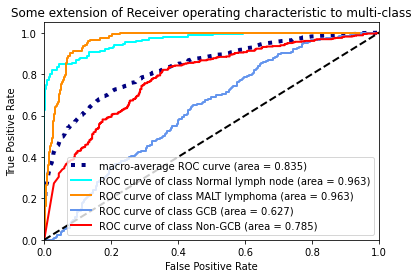

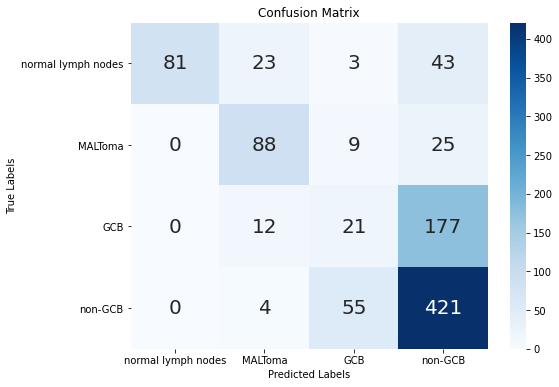

/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yamaguchi/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 4------------------------------------------------------------------------------
epoch:1 loss: 0.999 acc: 56.346
The current loss: 0.8284251289469654
trigger times: 0


In [ ]:
%%time

def main():
    
    for _fold, (train_index, valid_index) in enumerate(kf.split(np.arange(len(train_dataset)))):
    
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # SqueezeNetモデルを事前学習済みモデルとしてロード
        model = models.squeezenet1_1(pretrained=True)

        # SqueezeNetの最終層の入力特徴量数を取得
        # SqueezeNetではclassifierの第2層が最終層です
        num_ftrs = model.classifier[1].in_channels

        # 最終層を4クラスの出力に変更
        model.classifier[1] = nn.Conv2d(num_ftrs, 4, kernel_size=(1,1))

        # 最終層の出力の形状を変更
        model.num_classes = 4

        # すべての層を訓練可能に設定
        for param in model.parameters():
            param.requires_grad = True

        # モデルをデバイスに移動
        model = model.to(device)
        batch_size = 32
        criterion = nn.CrossEntropyLoss()
        # Pass all model parameters to the optimizer
        optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9) # Optimize the entire model for fine-tuning
        
        cv_train_dataset = Subset(train_dataset, train_index)
        cv_train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
        cv_valid_dataset   = Subset(train_dataset, valid_index)
        cv_valid_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)
        
        print('Fold {}------------------------------------------------------------------------------'.format(_fold+1))

        model = train(device, model, optimizer, criterion, cv_train_dataloader, cv_valid_dataloader)
        test(device, model, test_dataloader)


if __name__ == '__main__':
    main()